In [1]:
import numpy as np
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

# Moindres-carrés - Solution numérique

## Solveur direct

On a vu que la solution par moindres-carrés du problème inverse linéaire est

$\mathbf{m}^{\text{est}} = \left[\mathbf{G}^T\mathbf{G}\right]^{-1}\mathbf{G}^T\mathbf{d}$

qui est un problème de la forme $\mathbf{Ax} = \mathbf{b}$ qui peut être résolu numériquement de plusieurs façon, selon les propriétés de la matrice $\mathbf{A}$.

Une façon de procéder est de 
- calculer la matrice $\mathbf{G}^T\mathbf{G}$, qu'on stock dans $\mathbf{A}$
- calculer l'inverse de $\mathbf{A}$
- calculer le vecteur $\mathbf{G}^T\mathbf{d}$, qu'on stock dans $\mathbf{b}$
- calculer le produit $\mathbf{A}^{-1}\mathbf{b}$

En python, on peut utiliser la fonction ```numpy.linalg.solve``` pour ce faire.

In [2]:
help(np.linalg.solve)

Help on function solve in module numpy.linalg.linalg:

solve(a, b)
    Solve a linear matrix equation, or system of linear scalar equations.
    
    Computes the "exact" solution, `x`, of the well-determined, i.e., full
    rank, linear matrix equation `ax = b`.
    
    Parameters
    ----------
    a : (..., M, M) array_like
        Coefficient matrix.
    b : {(..., M,), (..., M, K)}, array_like
        Ordinate or "dependent variable" values.
    
    Returns
    -------
    x : {(..., M,), (..., M, K)} ndarray
        Solution to the system a x = b.  Returned shape is identical to `b`.
    
    Raises
    ------
    LinAlgError
        If `a` is singular or not square.
    
    Notes
    -----
    
    .. versionadded:: 1.8.0
    
    Broadcasting rules apply, see the `numpy.linalg` documentation for
    details.
    
    The solutions are computed using LAPACK routine _gesv
    
    `a` must be square and of full-rank, i.e., all rows (or, equivalently,
    columns) must be linea

L'inversion de la matrice est transparente pour l'utilisateur, la fonction ```solve``` retourne le vecteur solution.

```solve``` utilise la routine ```gesv``` de la librarie LAPACK.  La documentation de cette routine précise que:
```
 gesv computes the solution to a real or complex linear system of
 equations A*X = B, where A is a square matrix and X and B are 
 rectangular matrices or vectors. Gaussian elimination with row 
 interchanges is used to factor A as A = P*L*U , where P is a permutation
 matrix, L is unit lower triangular, and U is upper triangular. The 
 factored form of A is then used to solve the above system.
 ```


### Utilisation

Examinons un exemple de l'ajustement d'une droite en créant d'abord des points des points plus ou moins alignés.

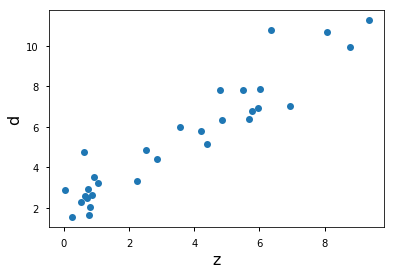

In [3]:
N = 30
zmin = 0
zmax = 10
z = np.sort(zmin + zmax*np.random.rand(N, 1), axis=0)

a = 2.0
b = 1.0
m = [a, b]
sd = 1.0
dobs = m[0] + m[1] * z + sd*np.random.randn(N, 1)

plt.plot(z, dobs, 'o')
plt.xlabel('z', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.show()

Le modèle $\mathbf{m}$ est

\begin{equation}
\begin{bmatrix}
m_0 \\
m_1 
\end{bmatrix}
\end{equation}

Les données observées sont placées dans un vecteur $\mathbf{d}$:

\begin{equation}
\begin{bmatrix}
d_0 \\
d_1 \\
d_2 \\
\vdots \\
d_{N-1}
\end{bmatrix}
\end{equation}

On peut ainsi construire la matrice $\mathbf{G}$, qui est égale à

\begin{equation}
\begin{bmatrix}
1 & z_0 \\
1 & z_1 \\
1 & z_2 \\
\vdots & \vdots \\
1 & z_{N-1}
\end{bmatrix}
\end{equation}

In [4]:
G = np.hstack((np.ones((N, 1)), z))

On peut passer $\mathbf{G}^T\mathbf{G}$ et $\mathbf{G}^T\mathbf{d}$ directement en argument à ```numpy.linalg.solve```

In [5]:
mest = np.linalg.solve(G.T.dot(G), G.T.dot(dobs))
print(mest)
dpre = G.dot(mest)

[[2.01820659]
 [0.95676671]]


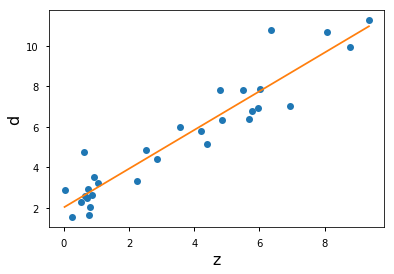

In [6]:
plt.plot(z, dobs, 'o')
plt.plot(z, dpre, '-')
plt.xlabel('z', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.show()

## Solveurs itératifs

Pour des problèmes courants, $N$ sera beaucoup plus élevé que 30.  Surtout, $M$ sera aussi plus grand que 2.  Par exemple, pour un inversion en gravimétrie sur une grille 3D de $100 \times 100 \times 100$, $M$ vaut $10^6$

Le calcul de $\mathbf{G}^T\mathbf{G}$ peut alors être coûteux, en temps et en mémoire.  Le calcul de son inverse est également coûteux, voire prohibitif.

On peut recourir à des solveurs _itératifs_ pour accélérer les calculs.

Examinons le cas d'une équation cubique.

In [7]:
N = 100000

z = np.sort(zmin + zmax*np.random.rand(N, 1), axis=0)

a = 2.0
b = 1.0
c = 0.5
d = -0.05
m = [a, b, c, d]
sd = 1.0
dobs = m[0] + m[1]*z + m[2]*z**2 + m[3]*z**3 + sd*np.random.randn(N, 1)

G = np.hstack((np.ones((N, 1)), z, z**2, z**3))

mest1 = np.linalg.solve(G.T.dot(G), G.T.dot(dobs))

print(m)
print(mest1.flatten())

[2.0, 1.0, 0.5, -0.05]
[ 2.0083834   0.99226062  0.50291786 -0.05024582]


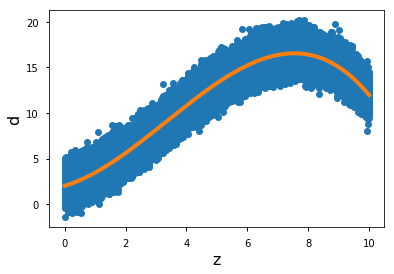

In [8]:
dpre1 = G.dot(mest1)
plt.plot(z, dobs, 'o')
plt.plot(z, dpre1, '-', linewidth=4)
plt.xlabel('z', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.show()

L'algorithme du gradient biconjugué implémenté dans le module ```scipy.sparse.linalg``` est utilisé pour cet exemple.  Cette implémentation permet l'utilisation d'un objet ```LinearOperator``` à la place de la matrice $\mathbf{A}$, ce qui permet _d'éviter entièrement le calcul_ de $\mathbf{G}^T\mathbf{G}$

In [9]:
help(sp.bicg)

Help on function bicg in module scipy.sparse.linalg.isolve.iterative:

bicg(A, b, x0=None, tol=1e-05, maxiter=None, M=None, callback=None)
    Use BIConjugate Gradient iteration to solve ``Ax = b``.
    
    Parameters
    ----------
    A : {sparse matrix, dense matrix, LinearOperator}
        The real or complex N-by-N matrix of the linear system.
        It is required that the linear operator can produce
        ``Ax`` and ``A^T x``.
    b : {array, matrix}
        Right hand side of the linear system. Has shape (N,) or (N,1).
    
    Returns
    -------
    x : {array, matrix}
        The converged solution.
    info : integer
        Provides convergence information:
            0  : successful exit
            >0 : convergence to tolerance not achieved, number of iterations
            <0 : illegal input or breakdown
    
    Other Parameters
    ----------------
    x0  : {array, matrix}
        Starting guess for the solution.
    tol : float
        Tolerance to achieve. The

In [10]:
help(sp.LinearOperator)

Help on class LinearOperator in module scipy.sparse.linalg.interface:

class LinearOperator(builtins.object)
 |  Common interface for performing matrix vector products
 |  
 |  Many iterative methods (e.g. cg, gmres) do not need to know the
 |  individual entries of a matrix to solve a linear system A*x=b.
 |  Such solvers only require the computation of matrix vector
 |  products, A*v where v is a dense vector.  This class serves as
 |  an abstract interface between iterative solvers and matrix-like
 |  objects.
 |  
 |  To construct a concrete LinearOperator, either pass appropriate
 |  callables to the constructor of this class, or subclass it.
 |  
 |  A subclass must implement either one of the methods ``_matvec``
 |  and ``_matmat``, and the attributes/properties ``shape`` (pair of
 |  integers) and ``dtype`` (may be None). It may call the ``__init__``
 |  on this class to have these attributes validated. Implementing
 |  ``_matvec`` automatically implements ``_matmat`` (using a 

In [11]:
M = 4
def lsfcn(v):
    return G.T.dot(G.dot(v))

# G est une matrice réelle, on peut utiliser lsfcn pour rmatvec

A = sp.LinearOperator((M, M), matvec=lsfcn, rmatvec=lsfcn) 


L'objet ```A``` est reconnu par l'algorithme et sa méthode ```matvec``` est utilisée au lieu de calculer explicitement le produit $\mathbf{Ax}$.

In [12]:
tol = 1.e-6
maxit = 3*N
mest2, info = sp.bicg(A, G.T.dot(dobs), tol=tol, maxiter=maxit)

print(m)
print(mest2)

[2.0, 1.0, 0.5, -0.05]
[ 2.0083834   0.99226062  0.50291786 -0.05024582]


Les paramètres de convergence sont importants...

In [13]:
mest3, info = sp.bicg(A, G.T.dot(dobs))

print(m)
print(mest3)

[2.0, 1.0, 0.5, -0.05]
[ 1.35094724  1.55623244  0.38302655 -0.04300556]


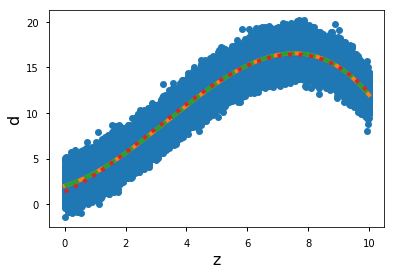

In [14]:
dpre2 = G.dot(mest2)
dpre3 = G.dot(mest3)

plt.plot(z, dobs, 'o')
plt.plot(z, dpre1, '-', linewidth=4)
plt.plot(z, dpre2, '--', linewidth=4)
plt.plot(z, dpre3, ':', linewidth=4)

plt.xlabel('z', fontsize=16)
plt.ylabel('d', fontsize=16)
plt.show()